In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the dataset
df = pd.read_csv(r"C:\Users\noorh\Downloads\final_internship_data.csv")

# Show initial structure
print(df.head())

    User ID          User Name       Driver Name Car Condition Weather  \
0  KHVrEVlD     Kimberly Adams        Amy Butler     Very Good   windy   
1  lPxIuEri       Justin Tapia  Hannah Zimmerman     Excellent  cloudy   
2  gsVN8JLS    Elizabeth Lopez    Amanda Jackson           Bad  stormy   
3  9I7kWFgd      Steven Wilson          Amy Horn     Very Good  stormy   
4  8QN5ZaGN  Alexander Andrews  Cassandra Larson           Bad  stormy   

   Traffic Condition      key  fare_amount pickup_datetime  pickup_longitude  \
0  Congested Traffic  26:21.0          4.5        06/15/09         -1.288826   
1       Flow Traffic  52:16.0         16.9        01/05/10         -1.291824   
2  Congested Traffic  35:00.0          5.7        08/18/11         -1.291242   
3       Flow Traffic  30:42.0          7.7        04/21/12         -1.291319   
4  Congested Traffic  51:00.0          5.3        03/09/10         -1.290987   

   ...  month  weekday  year   jfk_dist   ewr_dist   lga_dist   sol_dist  

In [2]:
df_clean = df.dropna()


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   User ID            500000 non-null  object 
 1   User Name          500000 non-null  object 
 2   Driver Name        500000 non-null  object 
 3   Car Condition      500000 non-null  object 
 4   Weather            500000 non-null  object 
 5   Traffic Condition  500000 non-null  object 
 6   key                500000 non-null  object 
 7   fare_amount        500000 non-null  float64
 8   pickup_datetime    500000 non-null  object 
 9   pickup_longitude   500000 non-null  float64
 10  pickup_latitude    500000 non-null  float64
 11  dropoff_longitude  499995 non-null  float64
 12  dropoff_latitude   499995 non-null  float64
 13  passenger_count    500000 non-null  int64  
 14  hour               500000 non-null  int64  
 15  day                500000 non-null  int64  
 16  mo

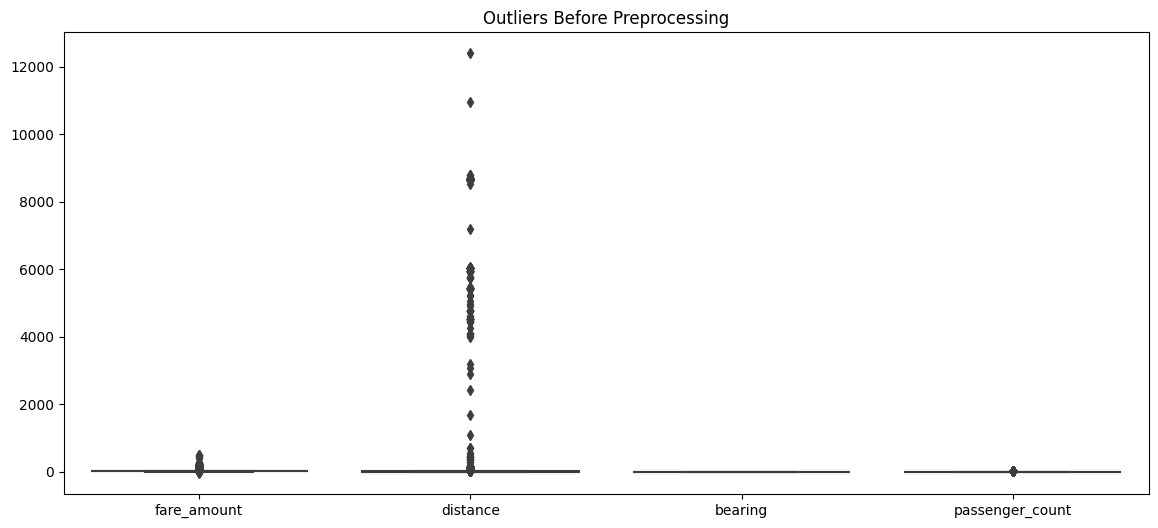

In [4]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df[['fare_amount', 'distance','bearing','passenger_count']])
plt.title('Outliers Before Preprocessing')
plt.show()



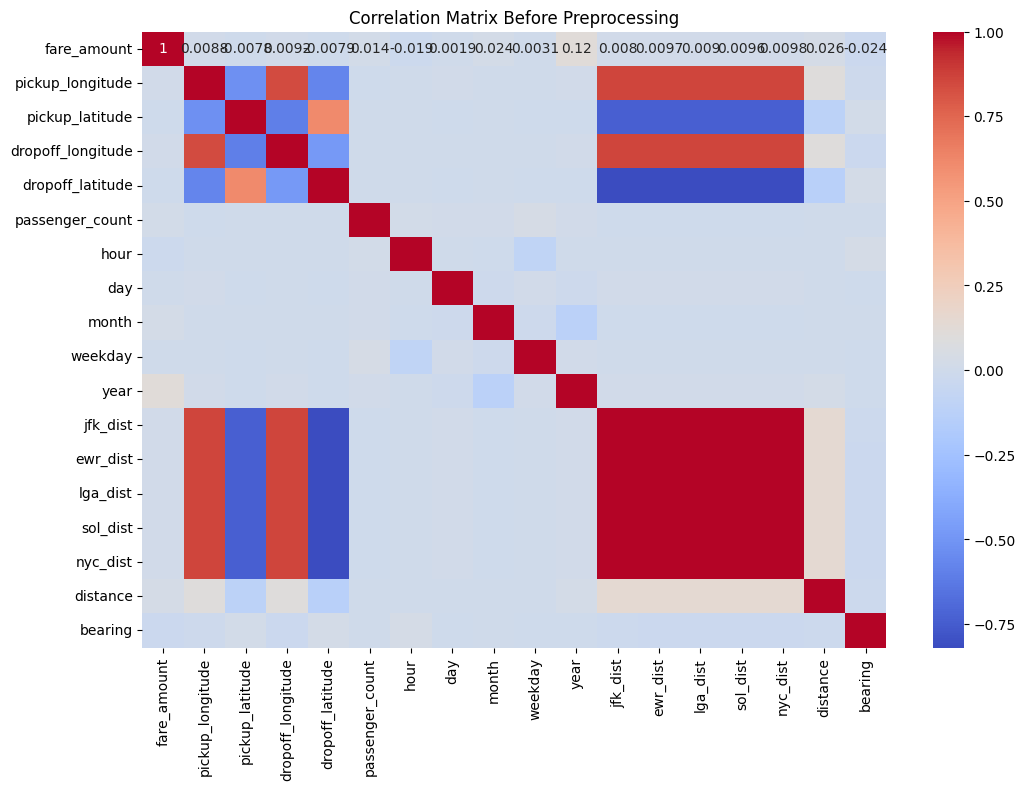

In [5]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Before Preprocessing')
plt.show()

In [6]:
# 4. VIF Before Preprocessing
def calculate_vif(df):
    numeric_df = df.select_dtypes(include=[np.number]).dropna()
    vif_data = pd.DataFrame()
    vif_data["feature"] = numeric_df.columns
    vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, i)
                       for i in range(len(numeric_df.columns))]
    return vif_data

print("\nVIF Before Preprocessing:")
print(calculate_vif(df))


VIF Before Preprocessing:
              feature           VIF
0         fare_amount  3.483664e+00
1    pickup_longitude  2.300036e+02
2     pickup_latitude  6.664533e+01
3   dropoff_longitude  3.668751e+02
4    dropoff_latitude  2.568692e+02
5     passenger_count  2.663593e+00
6                hour  5.363271e+00
7                 day  4.265900e+00
8               month  4.328184e+00
9             weekday  3.475859e+00
10               year  2.002834e+03
11           jfk_dist  4.500464e+05
12           ewr_dist  3.684913e+06
13           lga_dist  4.356686e+05
14           sol_dist  2.021484e+07
15           nyc_dist  1.087837e+07
16           distance  1.030370e+00
17            bearing  1.037942e+00


In [7]:
cols_to_drop = ['User ID','User Name', 'Driver Name', 'key','dropoff_latitude',
                'dropoff_longitude','pickup_datetime','pickup_longitude','pickup_latitude']
df_clean = df.drop(columns=cols_to_drop)
df_clean = df_clean.dropna()
df_clean = df_clean[df_clean['fare_amount'].between(2, 200)]


In [8]:
for col in [ 'distance']:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]


In [9]:
df_clean['fare_amount'] = np.log1p(df_clean['fare_amount'])
df_clean['distance'] = np.log1p(df_clean['distance'])

In [10]:
pca_cols = ['jfk_dist', 'ewr_dist', 'lga_dist', 'sol_dist', 'nyc_dist']
scaler_pca = StandardScaler()
pca = PCA(n_components=1)
df_clean['airport_pca'] = pca.fit_transform(scaler_pca.fit_transform(df_clean[pca_cols]))
df_clean.drop(columns=pca_cols, inplace=True)

In [11]:
categorical = ['Car Condition', 'Weather', 'Traffic Condition']
df_clean = pd.get_dummies(df_clean, columns=categorical, drop_first=True)

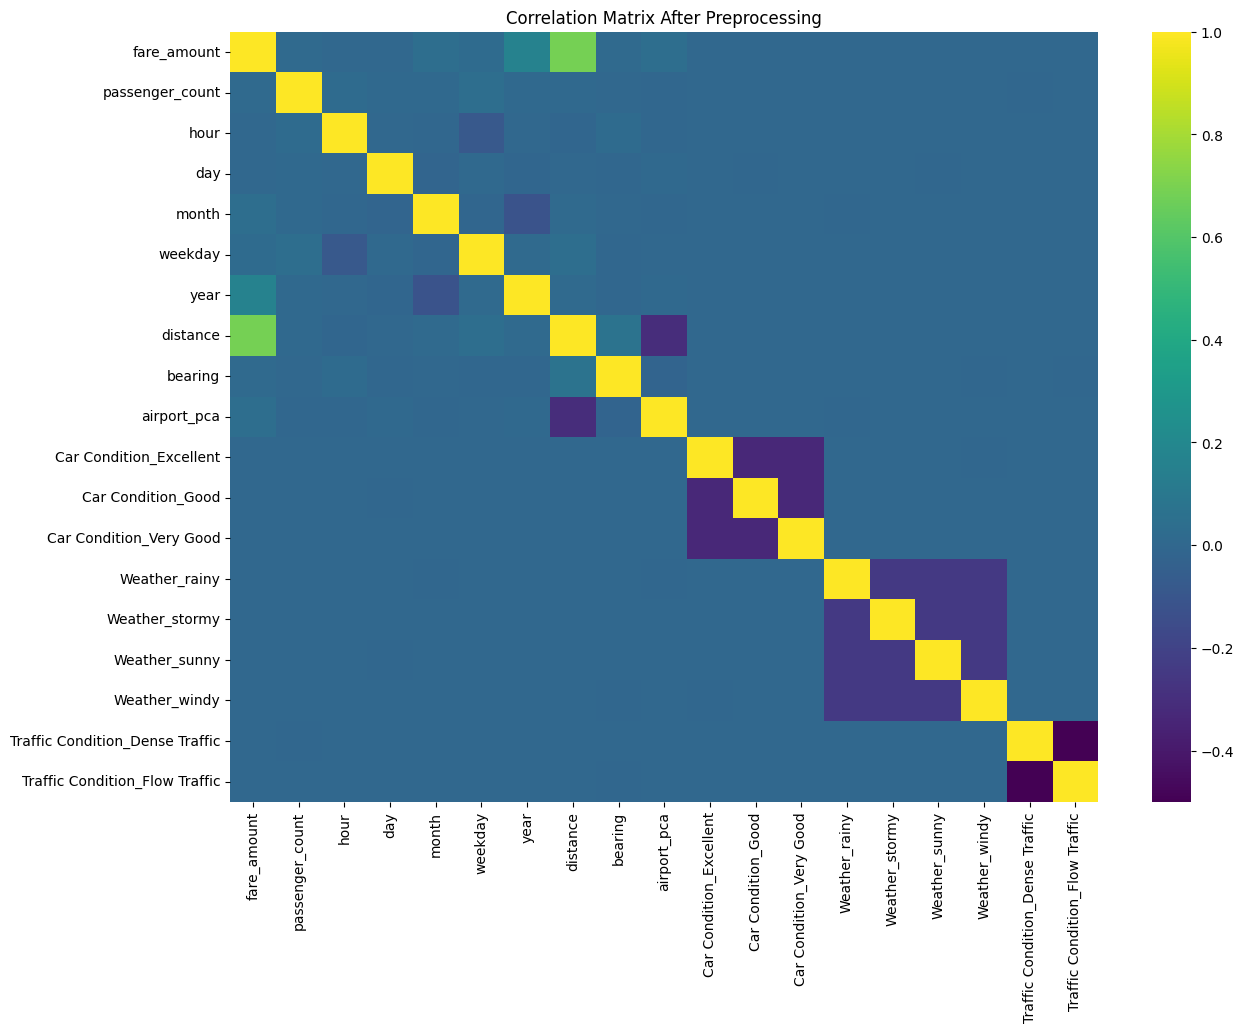

In [12]:
plt.figure(figsize=(14, 10))
sns.heatmap(df_clean.corr(), annot=False, cmap='viridis')
plt.title('Correlation Matrix After Preprocessing')
plt.show()

In [13]:
print("\nVIF After Preprocessing:")
print(calculate_vif(df_clean.drop(columns=['fare_amount'])))


VIF After Preprocessing:
           feature        VIF
0  passenger_count   2.661869
1             hour   5.448049
2              day   4.263923
3            month   4.309843
4          weekday   3.487747
5             year  21.810165
6         distance   6.752433
7          bearing   1.036679
8      airport_pca   1.105491


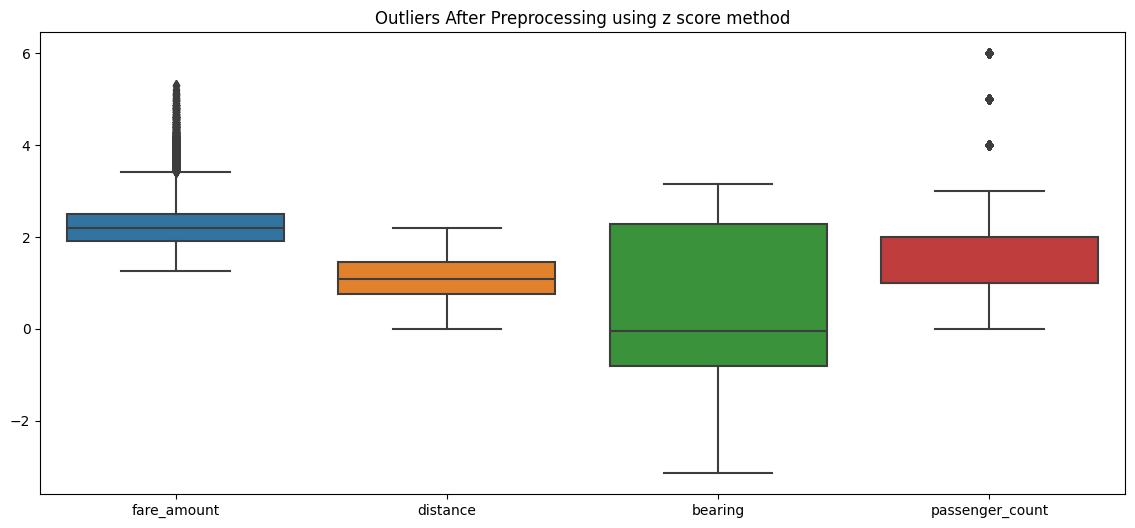

In [20]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_clean[['fare_amount', 'distance','bearing','passenger_count']])
plt.title('Outliers After Preprocessing using z score method')
plt.show()


In [15]:
# 13. Train/Test Split
X = df_clean.drop(columns='fare_amount')
y = df_clean['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# 14. Model Training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [17]:
y_pred = model.predict(X_test)
print("\nModel Evaluation:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")


Model Evaluation:
RMSE: 0.235
R² Score: 0.695
